# **Speed Comparison between the Base EGNN [1] and Our JAX Implementation**
[1] Satorras, V. G., Hoogeboom, E., & Welling, M. (2021). E(n) Equivariant Graph Neural Networks. In Proceedings of the 38th International Conference on Machine Learning, 139. https://doi.org/10.48550/ARXIV.2102.09844

Some of the code has been adapted from the following source: https://github.com/maxxxzdn/jax-geometric by Maksim Zhdanov.

## **1. Load up the repositories**

In [1]:
import os
from pathlib import Path

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import userdata
    repo_name = 'vgsatorras/egnn'
    url = f"https://{userdata.get('gh_pat')}@github.com/{repo_name}.git"
    !git clone --branch main {url}
    #%cd egnn

Cloning into 'egnn'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 92 (delta 10), reused 4 (delta 4), pack-reused 66
Receiving objects: 100% (92/92), 297.25 KiB | 19.82 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [2]:
import os
from pathlib import Path

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import userdata
    repo_name = 'stefanvasilev/egnn-transformer'
    url = f"https://{userdata.get('gh_pat')}@github.com/{repo_name}.git"
    !git clone --branch main {url}


Cloning into 'egnn-transformer'...
remote: Enumerating objects: 1501, done.
remote: Counting objects: 100% (613/613), done.
remote: Compressing objects: 100% (276/276), done.
remote: Total 1501 (delta 372), reused 509 (delta 335), pack-reused 888
Receiving objects: 100% (1501/1501), 4.13 MiB | 9.51 MiB/s, done.
Resolving deltas: 100% (875/875), done.


## **2. Timing test of the Pytorch EGNN**

In [78]:
%cd egnn

/content/egnn


In [ ]:
import argparse
import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
from models.gcl import E_GCL, unsorted_segment_sum
from qm9.models import EGNN

parser = argparse.ArgumentParser()
parser.add_argument('--hidden_features', type=int, default=256)
parser.add_argument('--edge_features', type=int, default=1)
parser.add_argument('--out_features', type=int, default=1)
parser.add_argument('--n_layers', type=int, default=3)
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--min_nodes', type=int, default=5)
parser.add_argument('--max_nodes', type=int, default=50)
parser.add_argument('--step_nodes', type=int, default=5)
parser.add_argument('--n_warmup', type=int, default=10)
parser.add_argument('--n_iter', type=int, default=100)
parser.add_argument('--n_measurements', type=int, default=10)
parser.add_argument('--output_file', type=str, default='timing_results.json')

#needed for collab
args, unknown = parser.parse_known_args()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# use Syntetic data
def get_edges(n_nodes):
    rows, cols = [], []
    for i in range(n_nodes):
        for j in range(n_nodes):
            if i != j:
                rows.append(i)
                cols.append(j)
    return [rows, cols]

def get_edges_batch(n_nodes, batch_size):
    edges = get_edges(n_nodes)
    edge_attr = torch.ones(len(edges[0]) * batch_size, 1).to(device)
    edges = [torch.LongTensor(edges[0]).to(device), torch.LongTensor(edges[1]).to(device)]
    if batch_size == 1:
        return edges, edge_attr
    elif batch_size > 1:
        rows, cols = [], []
        for i in range(batch_size):
            rows.append(edges[0] + n_nodes * i)
            cols.append(edges[1] + n_nodes * i)
        edges = [torch.cat(rows), torch.cat(cols)]
    return edges, edge_attr


def run_timing_test(n_nodes):
    durations = []

    node_features = torch.randn((args.batch_size * n_nodes, 15), dtype=torch.float).to(device)  # We are testing for features dimension of 15
    node_positions = torch.randn((args.batch_size * n_nodes, 3), dtype=torch.float).to(device)
    node_mask = torch.ones((args.batch_size * n_nodes, 1), dtype=torch.float).to(device)
    edges, edge_attr = get_edges_batch(n_nodes, args.batch_size)
    edge_mask = torch.ones(len(edges[0]), 1).to(device)


    model = EGNN(
        in_node_nf=15,
        in_edge_nf=args.edge_features,
        hidden_nf=args.hidden_features,
        device=device,
        n_layers=args.n_layers
    ).to(device)

    for measurement in tqdm.tqdm(range(args.n_measurements), desc=f'Nodes: {n_nodes}'):

        if measurement == 0:
            print(node_features.shape, node_positions.shape, edges[0].shape)
            print('Num. params:', sum(p.numel() for p in model.parameters() if p.requires_grad))

        for _ in range(args.n_warmup):
            _ = model(node_features, node_positions, edges, edge_attr, node_mask, edge_mask, n_nodes)
        torch.cuda.synchronize()

        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        start.record()
        for _ in range(args.n_iter):
            _ = model(node_features, node_positions, edges, edge_attr, node_mask, edge_mask, n_nodes)
        end.record()
        torch.cuda.synchronize()

        durations.append(0.001 * start.elapsed_time(end) / args.n_iter)

    mean_duration = np.mean(durations)
    std_duration = np.std(durations)

    return mean_duration, std_duration, durations

results = []
node_counts = list(range(args.min_nodes, args.max_nodes + 1, args.step_nodes))

for n_nodes in node_counts:
    mean_duration, std_duration, all_durations = run_timing_test(n_nodes)
    results.append({
        'n_nodes': n_nodes,
        'mean_duration': mean_duration,
        'std_duration': std_duration,
        'durations': all_durations
    })
    print(f'Nodes: {n_nodes}, Mean Duration: {mean_duration:.5f} s, Std Duration: {std_duration:.6f} s')


with open(args.output_file, 'w') as f:
    json.dump(results, f)

mean_durations = [result['mean_duration'] for result in results]
plt.figure(figsize=(10, 6))
plt.plot(node_counts, mean_durations, marker='o')
plt.xlabel('Number of Nodes')
plt.ylabel('Mean Duration (s)')
plt.title('Mean Duration per Number of Nodes - EGNN Pytorch')
plt.grid(True)
plt.savefig('timing_plot.png')
plt.show()

## **3. Timing test of the Jax EGNN**

In [73]:
%cd ../egnn-transformer

/content/egnn-transformer


Nodes: 5:   0%|          | 0/10 [00:00<?, ?it/s]

(640, 15) (2560,)
Num params: 22820


Nodes: 5: 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


Nodes: 5, Mean Duration: 0.00054 s, Std Duration: 0.000011 s


Nodes: 10:   0%|          | 0/10 [00:00<?, ?it/s]

(1280, 15) (11520,)
Num params: 22820


Nodes: 10: 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


Nodes: 10, Mean Duration: 0.00079 s, Std Duration: 0.000167 s


Nodes: 15:   0%|          | 0/10 [00:00<?, ?it/s]

(1920, 15) (26880,)
Num params: 22820


Nodes: 15: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Nodes: 15, Mean Duration: 0.00172 s, Std Duration: 0.000167 s


Nodes: 20:   0%|          | 0/10 [00:00<?, ?it/s]

(2560, 15) (48640,)
Num params: 22820


Nodes: 20: 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


Nodes: 20, Mean Duration: 0.00488 s, Std Duration: 0.000052 s


Nodes: 25:   0%|          | 0/10 [00:00<?, ?it/s]

(3200, 15) (76800,)
Num params: 22820


Nodes: 25: 100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


Nodes: 25, Mean Duration: 0.00808 s, Std Duration: 0.000053 s


Nodes: 30:   0%|          | 0/10 [00:00<?, ?it/s]

(3840, 15) (111360,)
Num params: 22820


Nodes: 30: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


Nodes: 30, Mean Duration: 0.01168 s, Std Duration: 0.000056 s


Nodes: 35:   0%|          | 0/10 [00:00<?, ?it/s]

(4480, 15) (152320,)
Num params: 22820


Nodes: 35: 100%|██████████| 10/10 [00:33<00:00,  3.36s/it]


Nodes: 35, Mean Duration: 0.02530 s, Std Duration: 0.000060 s


Nodes: 40:   0%|          | 0/10 [00:00<?, ?it/s]

(5120, 15) (199680,)
Num params: 22820


Nodes: 40: 100%|██████████| 10/10 [00:37<00:00,  3.79s/it]


Nodes: 40, Mean Duration: 0.03014 s, Std Duration: 0.000092 s


Nodes: 45:   0%|          | 0/10 [00:00<?, ?it/s]

(5760, 15) (253440,)
Num params: 22820


Nodes: 45: 100%|██████████| 10/10 [00:44<00:00,  4.42s/it]


Nodes: 45, Mean Duration: 0.03560 s, Std Duration: 0.000031 s


Nodes: 50:   0%|          | 0/10 [00:00<?, ?it/s]

(6400, 15) (313600,)
Num params: 22820


Nodes: 50: 100%|██████████| 10/10 [00:50<00:00,  5.05s/it]


Nodes: 50, Mean Duration: 0.04095 s, Std Duration: 0.000089 s


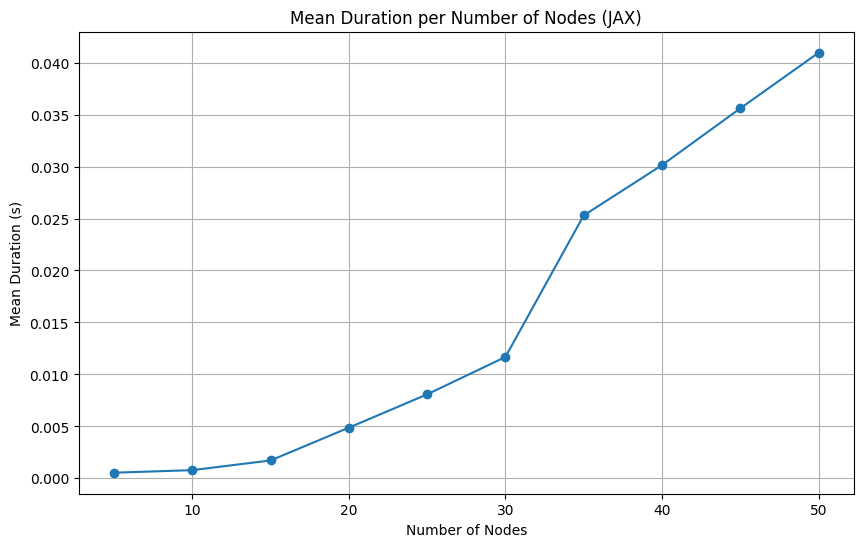

In [74]:
import jax
import jax.numpy as jnp
import time
import tqdm
import json
import jraph
import argparse
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from flax.training import checkpoints
from models2.egnn_jax import EGNN_QM9

# Argument Parser
parser = argparse.ArgumentParser()
parser.add_argument('--hidden_features', type=int, default=32)
parser.add_argument('--edge_features', type=int, default=1)
parser.add_argument('--out_features', type=int, default=1)
parser.add_argument('--n_layers', type=int, default=3)

parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--min_nodes', type=int, default=5)
parser.add_argument('--max_nodes', type=int, default=50)
parser.add_argument('--step_nodes', type=int, default=5)

parser.add_argument('--n_warmup', type=int, default=10)
parser.add_argument('--n_iter', type=int, default=100)
parser.add_argument('--n_measurements', type=int, default=10)

parser.add_argument('--output_file', type=str, default='timing_results_jax.json')

args, unknown = parser.parse_known_args()

# use Syntetic data
def get_edges_batch_jax(n_nodes, batch_size):
    edges = get_edges(n_nodes)
    edge_attr = jnp.ones((len(edges[0]) * batch_size, 1))
    edges = [jnp.array(edges[0]), jnp.array(edges[1])]
    if batch_size == 1:
        return edges, edge_attr
    elif batch_size > 1:
        rows, cols = [], []
        for i in range(batch_size):
            rows.append(edges[0] + n_nodes * i)
            cols.append(edges[1] + n_nodes * i)
        edges = [jnp.concatenate(rows), jnp.concatenate(cols)]
    return edges, edge_attr

def get_edges(n_nodes):
    rows, cols = [], []
    for i in range(n_nodes):
        for j in range(n_nodes):
            if i != j:
                rows.append(i)
                cols.append(j)
    return [rows, cols]

def create_graph(h, x, edges, edge_attr):
    n_node = jnp.array([h.shape[0]])
    n_edge = jnp.array([edges.shape[1]])

    graphs_tuple = jraph.GraphsTuple(
            nodes=h,
            edges=edge_attr,
            senders=edges[0],
            receivers=edges[1],
            globals=None,
            n_node=n_node,
            n_edge=n_edge
        )

    return graphs_tuple

def create_padding_mask(h, x, edges, edge_attr):
    graph = create_graph(h, x, edges, edge_attr)
    node_mask = jraph.get_node_padding_mask(graph)
    manual_node_mask = (h.sum(axis=1) != 0).astype(jnp.float32)

    if node_mask.sum() == 0:
        node_mask = manual_node_mask

    return node_mask

@partial(jax.jit, static_argnames=['n_nodes'])
def jit_apply(params, h, x, edges, edge_attr, node_mask, n_nodes):
    egnn = EGNN_QM9(
        hidden_nf=args.hidden_features,
        out_node_nf=args.out_features,
        n_layers=args.n_layers
    )
    return egnn.apply(params, h, x, edges, edge_attr, node_mask, n_nodes)


def run_timing_test(n_nodes):
    durations = []

    key = jax.random.PRNGKey(42)

    egnn = EGNN_QM9(
        hidden_nf=args.hidden_features,
        out_node_nf=args.out_features,
        n_layers=args.n_layers
    )

    for measurement in tqdm.tqdm(range(args.n_measurements), desc=f'Nodes: {n_nodes}'):
        key = jax.random.PRNGKey(42 + measurement)
        h = jax.random.normal(key, (args.batch_size * n_nodes, 15))
        x = jax.random.normal(key, (args.batch_size * n_nodes, 3))
        edges, edge_attr = get_edges_batch_jax(n_nodes, args.batch_size)
        node_mask = jnp.ones((args.batch_size * n_nodes, 1))
        edge_mask = jnp.ones(len(edges[0]))

        params = egnn.init(jax.random.PRNGKey(42 + measurement), h, x, edges, edge_attr, node_mask, n_nodes)

        if measurement == 0:
            print(h.shape, edges[0].shape)
            print(f"Num params: {sum(x.size for x in jax.tree.leaves(params))}")

        for _ in range(args.n_warmup):
            _ = jit_apply(params, h, x, edges, edge_attr, node_mask, n_nodes)
        jax.block_until_ready(_)

        start = time.time()
        for _ in range(args.n_iter):
            _ = jit_apply(params, h, x, edges, edge_attr, node_mask, n_nodes)
        jax.block_until_ready(_)
        end = time.time()

        durations.append((end - start) / args.n_iter)

    mean_duration = np.mean(durations)
    std_duration = np.std(durations)

    return mean_duration, std_duration, durations

results = []
node_counts = list(range(args.min_nodes, args.max_nodes + 1, args.step_nodes))

for n_nodes in node_counts:
    mean_duration, std_duration, all_durations = run_timing_test(n_nodes)
    results.append({
        'n_nodes': n_nodes,
        'mean_duration': mean_duration,
        'std_duration': std_duration,
        'durations': all_durations
    })
    print(f'Nodes: {n_nodes}, Mean Duration: {mean_duration:.5f} s, Std Duration: {std_duration:.6f} s')

with open(args.output_file, 'w') as f:
    json.dump(results, f)

mean_durations = [result['mean_duration'] for result in results]
plt.figure(figsize=(10, 6))
plt.plot(node_counts, mean_durations, marker='o')
plt.xlabel('Number of Nodes')
plt.ylabel('Mean Duration (s)')
plt.title('Mean Duration per Number of Nodes (JAX)')
plt.grid(True)
plt.savefig('timing_plot_jax.png')
plt.show()

## **4. Plotting the results**

In [75]:
import json

with open('/content/egnn-transformer/timing_results_jax.json', 'r') as f:
    jax_results = json.load(f)

with open('/content/egnn/timing_results.json', 'r') as f:
    pytorch_results = json.load(f)

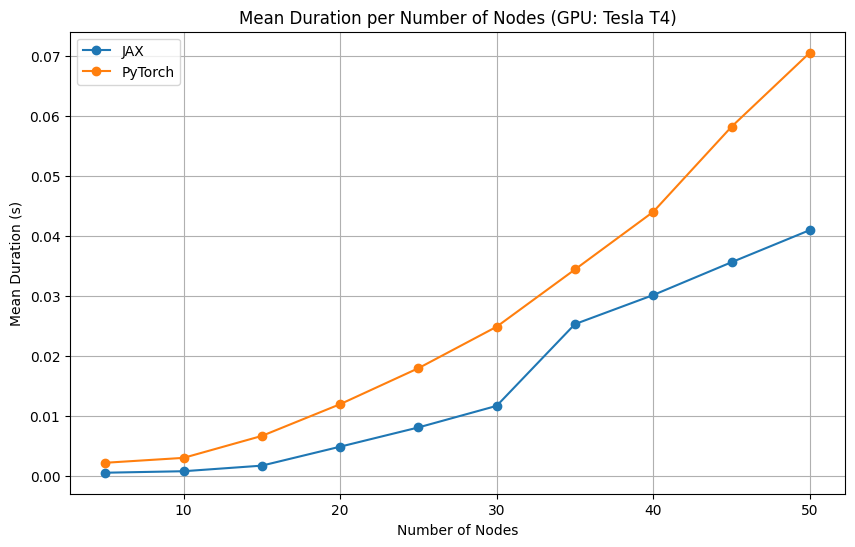

In [76]:
import matplotlib.pyplot as plt

jax_node_counts = [result['n_nodes'] for result in jax_results]
jax_mean_durations = [result['mean_duration'] for result in jax_results]

pytorch_node_counts = [result['n_nodes'] for result in pytorch_results]
pytorch_mean_durations = [result['mean_duration'] for result in pytorch_results]

# get session GPU info
gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv,noheader

plt.figure(figsize=(10, 6))
plt.plot(jax_node_counts, jax_mean_durations, marker='o', label='JAX')
plt.plot(pytorch_node_counts, pytorch_mean_durations, marker='o', label='PyTorch')
plt.xlabel('Number of Nodes')
plt.ylabel('Mean Duration (s)')
plt.title(f'Mean Duration per Number of Nodes (GPU: {gpu_info[0]})')
plt.legend()
plt.grid(True)
plt.savefig('timing_comparison_plot.png')
plt.show()


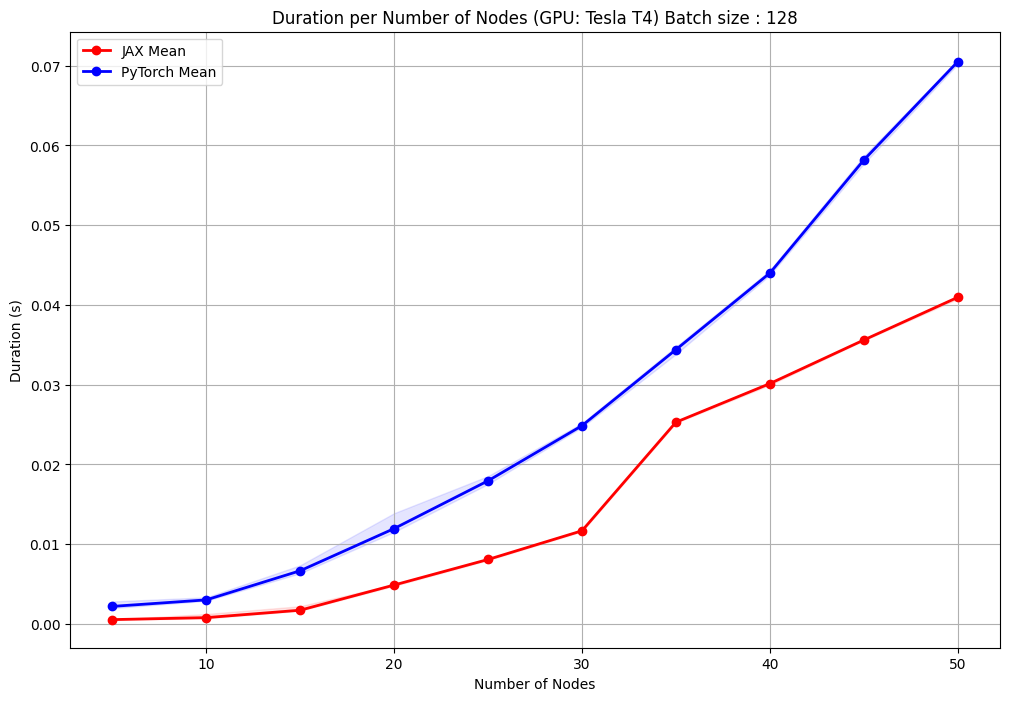

In [77]:
## use actual durations as a transparent mask for better insights
jax_node_counts = [result['n_nodes'] for result in jax_results]
jax_mean_durations = [result['mean_duration'] for result in jax_results]
jax_individual_durations = [result['durations'] for result in jax_results]

pytorch_node_counts = [result['n_nodes'] for result in pytorch_results]
pytorch_mean_durations = [result['mean_duration'] for result in pytorch_results]
pytorch_individual_durations = [result['durations'] for result in pytorch_results]

gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv,noheader

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 8))

jax_min_durations = [np.min(durations) for durations in jax_individual_durations]
jax_max_durations = [np.max(durations) for durations in jax_individual_durations]
plt.fill_between(jax_node_counts, jax_min_durations, jax_max_durations, color='red', alpha=0.1)

pytorch_min_durations = [np.min(durations) for durations in pytorch_individual_durations]
pytorch_max_durations = [np.max(durations) for durations in pytorch_individual_durations]
plt.fill_between(pytorch_node_counts, pytorch_min_durations, pytorch_max_durations, color='blue', alpha=0.1)

plt.plot(jax_node_counts, jax_mean_durations, marker='o', color='red', label='JAX Mean', linestyle='-', linewidth=2)

plt.plot(pytorch_node_counts, pytorch_mean_durations, marker='o', color='blue', label='PyTorch Mean', linestyle='-', linewidth=2)

plt.xlabel('Number of Nodes')
plt.ylabel('Duration (s)')
plt.title(f'Duration per Number of Nodes (GPU: {gpu_info[0]}) Batch size : 128')
plt.legend()
plt.grid(True)
plt.savefig('timing_comparison_plot.png')
plt.show()
